In [2]:
import pandas
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
import xlsxwriter


In [4]:
# Read the dataset
df = pandas.read_csv("data.csv")
df.rename(columns=lambda x: x.strip(), inplace=True)
df.drop(columns=["Net Income Flag"], inplace=True)

In [5]:
# Seperate the class label from other features
X = df.drop(columns=["Bankrupt?"])
y = df["Bankrupt?"]

In [6]:
# Calculate the ANOVA F-values
f_values = f_classif(X, y)[0]
for i in range(len(f_values)):
    f_values[i] = round(f_values[i], 4)

f_values = dict(zip(X.columns, f_values)) # Create dictionary

In [7]:
# Calculate the mutual information values
mi_values = mutual_info_classif(X, y, random_state=0)
for i in range(len(mi_values)):
    mi_values[i] = round(mi_values[i], 4)

mi_values = dict(zip(X.columns, mi_values)) # Create dictionary

In [8]:
# Pick the best features for each feature selection method
f_features = SelectKBest(f_classif, k=10).fit(X, y).get_feature_names_out()
mi_features = SelectKBest(mutual_info_classif, k=10).fit(X, y).get_feature_names_out()

X_f = X.filter(items=f_features, axis=1)
X_mi = X.filter(items=mi_features, axis=1)

In [9]:
# Perform discretization on both datasets
enc = KBinsDiscretizer(n_bins=3, encode="onehot")
X_f_binned = enc.fit_transform(X_f)
X_mi_binned = enc.fit_transform(X_mi)

In [20]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

In [13]:
# Define k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)

In [14]:
# Define feature subsets from previous feature selection methods
feature_subsets = {
    "ANOVA F-value": X_f,
    "Mutual Information": X_mi
}

In [15]:
# Define evaluation metrics
evaluation_metrics = ["Accuracy", "F1-macro", "F1-micro"]

In [16]:
# Initialize results dictionary
results = {method: {metric: [] for metric in evaluation_metrics} for method in feature_subsets}


In [17]:
# Stratified 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [35]:

for method, X_selected in feature_subsets.items():
    # 10-fold cross-validation
    for train_index, test_index in skf.split(X_selected, y):
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train k-NN classifier
        knn.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = knn.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        auc = roc_auc_score(y_test, y_pred)
        
        # Store results
        results[method]["Accuracy"].append(accuracy)
        results[method]["F1-macro"].append(f1_macro)
        results[method]["F1-micro"].append(f1_micro)

In [ ]:

# Display results
for method, metrics in results.items():
    print(f"\nResults for {method} (10-fold CV):")
    for metric, values in metrics.items():
        print(f"{metric}: Mean = {np.mean(values):.4f}, Std = {np.std(values):.4f}")

Results for ANOVA F-value (10-fold CV):
Accuracy: Mean = 0.9665, Std = 0.0045
F1-macro: Mean = 0.6175, Std = 0.0552
F1-micro: Mean = 0.9665, Std = 0.0045

Results for Mutual Information (10-fold CV):
Accuracy: Mean = 0.9657, Std = 0.0019
F1-macro: Mean = 0.6098, Std = 0.0252
F1-micro: Mean = 0.9657, Std = 0.0019

In [37]:
# Random hold-out validation with 40% test set size
for method, X_selected in feature_subsets.items():
    for _ in range(10):  # Repeat 10 times for 10 random hold-out validations
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.4, stratify=y, random_state=42)
        
        # Train k-NN classifier
        knn.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = knn.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        auc = roc_auc_score(y_test, y_pred)
        
        # Store results
        results[method]["Accuracy"].append(accuracy)
        results[method]["F1-macro"].append(f1_macro)
        results[method]["F1-micro"].append(f1_micro)


In [ ]:
# Display results for hold-out validation
for method, metrics in results.items():
    print(f"\nResults for {method} (Hold-Out):")
    for metric, values in metrics.items():
        print(f"{metric}: Mean = {np.mean(values):.4f}, Std = {np.std(values):.4f}")

Results for ANOVA F-value (Hold-Out):
Accuracy: Mean = 0.9664, Std = 0.0043
F1-macro: Mean = 0.6162, Std = 0.0532
F1-micro: Mean = 0.9664, Std = 0.0043

Results for Mutual Information (Hold-Out):
Accuracy: Mean = 0.9657, Std = 0.0018
F1-macro: Mean = 0.6092, Std = 0.0243
F1-micro: Mean = 0.9657, Std = 0.0018

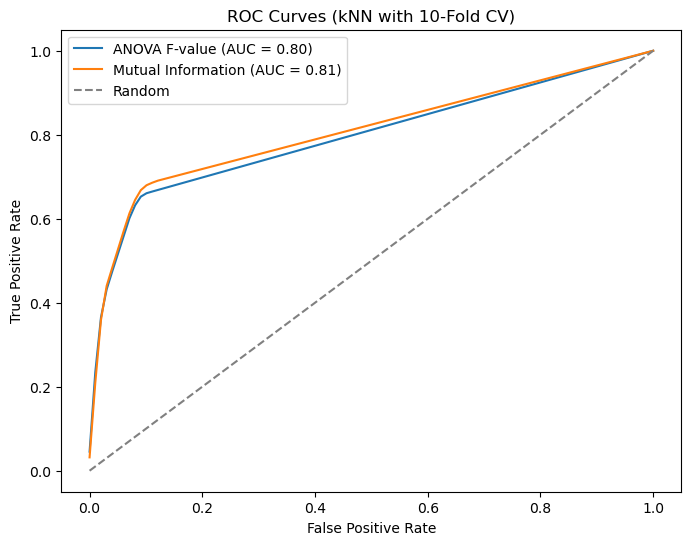

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Initialize dictionaries to store ROC curve data for kNN with 10-fold cross-validation
roc_curves_knn_cv = {method: {"fpr": [], "tpr": [], "roc_auc": []} for method in feature_subsets}

# Stratified 10-fold cross-validation for ROC curves with kNN
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for method, X_selected in feature_subsets.items():
    for train_index, test_index in skf.split(X_selected, y):
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train kNN classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        
        # Get predicted probabilities of positive class
        y_proba = knn.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # Store ROC curve data
        roc_curves_knn_cv[method]["fpr"].append(fpr)
        roc_curves_knn_cv[method]["tpr"].append(tpr)
        roc_curves_knn_cv[method]["roc_auc"].append(roc_auc)

# Plot ROC curves for kNN with 10-fold cross-validation
plt.figure(figsize=(8, 6))
for method, curve_data in roc_curves_knn_cv.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in zip(curve_data["fpr"], curve_data["tpr"]):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(curve_data["fpr"])  # Average across folds
    
    # Calculate mean AUC
    mean_auc = auc(mean_fpr, mean_tpr)
    
    # Plot mean ROC curve
    plt.plot(mean_fpr, mean_tpr, label=f'{method} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (kNN with 10-Fold CV)')
plt.legend()
plt.show()


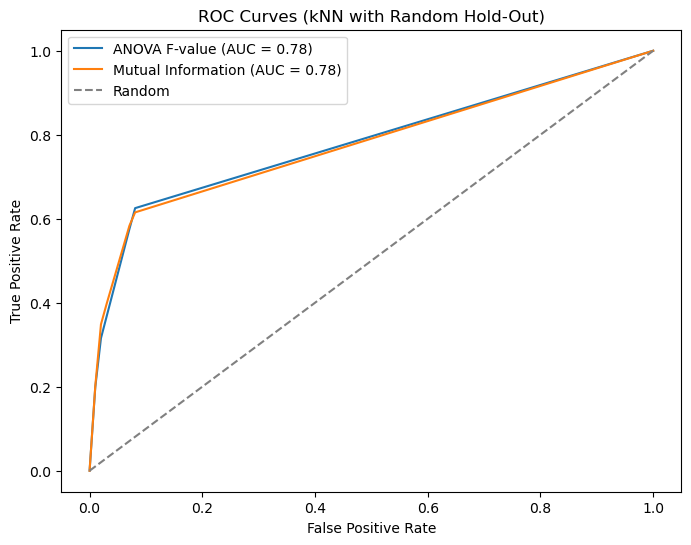

In [41]:
# Initialize dictionaries to store ROC curve data for kNN with random hold-out validation
roc_curves_knn_holdout = {method: {"fpr": [], "tpr": [], "roc_auc": []} for method in feature_subsets}

# Random hold-out validation with 40% test set size for ROC curves with kNN
for method, X_selected in feature_subsets.items():
    for _ in range(10):  # Repeat 10 times for 10 random hold-out validations
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.4, stratify=y, random_state=42)
        
        # Train kNN classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        
        # Get predicted probabilities of positive class
        y_proba = knn.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # Store ROC curve data
        roc_curves_knn_holdout[method]["fpr"].append(fpr)
        roc_curves_knn_holdout[method]["tpr"].append(tpr)
        roc_curves_knn_holdout[method]["roc_auc"].append(roc_auc)

# Plot ROC curves for kNN with random hold-out validation
plt.figure(figsize=(8, 6))
for method, curve_data in roc_curves_knn_holdout.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in zip(curve_data["fpr"], curve_data["tpr"]):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(curve_data["fpr"])  # Average across hold-out validations
    
    # Calculate mean AUC
    mean_auc = auc(mean_fpr, mean_tpr)
    
    # Plot mean ROC curve
    plt.plot(mean_fpr, mean_tpr, label=f'{method} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (kNN with Random Hold-Out)')
plt.legend()
plt.show()
